## Kaggle

In [0]:
!mkdir -p ~/.kaggle/

In [0]:
mv kaggle.json ~/.kaggle/

In [0]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 80.4MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 46.5MB/s]
  0% 0.00/661k [00:00<?, ?B/s]
100% 661k/661k [00:00<00:00, 95.9MB/s]
 95% 360M/377M [00:01<00:00, 222MB/s]
100% 377M/377M [00:01<00:00, 211MB/s]
100% 3.29G/3.29G [00:23<00:00, 127MB/s]
100% 3.29G/3.29G [00:23<00:00, 148MB/s]
  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 48.5kB/s]


In [0]:
!unzip -q stage_2_train_labels.csv.zip

In [0]:
!mkdir images

In [0]:
!unzip -q stage_2_train_images.zip -d images

In [0]:
!pip install pydicom

     |████████████████████████████████| 7.0MB 2.7MB/s 


In [0]:
import tensorflow as tf

from tensorflow.keras.optimizers import SGD
from tensorflow.train import AdamOptimizer

from tensorflow.python.keras.utils.data_utils import Sequence

from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Reshape, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, MaxPooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from keras.preprocessing import image

import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import matplotlib.image as mpimg
import numpy as np
import shutil
import os
import pandas as pd
import pylab
import pydicom

import re

Using TensorFlow backend.


In [0]:
tf.enable_eager_execution()

In [0]:
train_labels = pd.read_csv("stage_2_train_labels.csv")

In [0]:
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
train_labels["patientId"].unique().size

26684

In [0]:
images_paths = os.listdir("images")

In [0]:
X = [f'images/{image_path}' for image_path in images_paths]

In [0]:
original_image_width = 1024
original_image_height = 1024

y = []
boxes = []

for image_path in images_paths:
  image_name = image_path[:-4]
  patient_data = train_labels[train_labels["patientId"] == image_name]
  image_class = patient_data.iloc[0]["Target"]
  
  patient_boxes = []
  
  for patient in patient_data.values:
    box_width = patient[3]
    box_height = patient[4]
    
    if np.isnan(box_width):
      patient_boxes.append([0, 0, 0, 0])
    else:
      x_min = patient[1] / original_image_width
      y_min = patient[2] / original_image_height
      x_max = (patient[1] + box_width) / original_image_width
      y_max = (patient[2] + box_height) / original_image_height
      patient_boxes.append([x_min, y_min, x_max, y_max])
  
  boxes.append(patient_boxes)
  y.append(image_class)

In [0]:
!nvidia-smi

Fri Apr 26 02:04:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |   8813MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!cat /proc/meminfo

## Create new csv

In [0]:
training_information = pd.DataFrame({'X': X, 'y': y, 'boxes': boxes})

In [0]:
training_information.to_csv("training_information.csv")

In [0]:
training_information = pd.read_csv("training_information.csv")

In [0]:
training_information.head()

,Unnamed: 0,X,boxes,y
0,0,images/b89bd111-9093-46cd-a75c-c58c58b80824.dcm,"[[0, 0, 0, 0]]",0
1,1,images/651cd9f4-24c3-4ed0-9139-bb1595b18522.dcm,"[[0, 0, 0, 0]]",0
2,2,images/764ae03e-966a-48d2-ad73-bdbe10274eea.dcm,"[[0, 0, 0, 0]]",0
3,3,images/91b0043a-35bd-4cf9-b338-1cbc9b05b76d.dcm,"[[0, 0, 0, 0]]",0
4,4,images/7aea6188-dc10-4758-9a8e-b4d3de1dbc2d.dcm,"[[0, 0, 0, 0]]",0


## Images

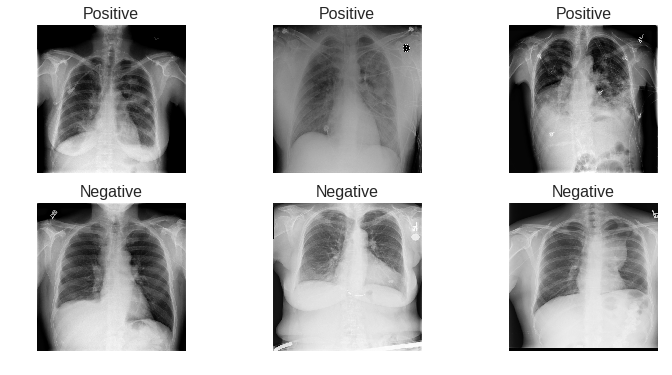

In [0]:
positive_images = training_information[training_information["y"] == 1]["X"][0:3]
negative_images = training_information[training_information["y"] == 0]["X"][0:3]

def plot_images(image_index, image_path, title):
  sp = figure.add_subplot(2, 3, image_index + 1)
  sp.axis('Off')
  dcm_data = pydicom.read_file(image_path)
  image_loaded = dcm_data.pixel_array
  sp.set_title(title, fontsize=16)
  plt.imshow(image_loaded, cmap=pylab.cm.gist_gray)

figure = plt.figure(figsize=(12, 6))

for image_index, image_path in enumerate(positive_images):
  plot_images(image_index, image_path, "Positive")

for image_index, image_path in enumerate(negative_images):
  plot_images(image_index + 3, image_path, "Negative")

## Match Boxes

In [0]:
def iou(box, anchor_box):  
  x_min = np.maximum(box[0], anchor_box[0])
  y_min = np.maximum(box[1], anchor_box[1])
  x_max = np.maximum(box[2], anchor_box[2])
  y_max = np.maximum(box[3], anchor_box[3])
  
  overlap_area = np.maximum(0.0, x_max - x_min + 1) * np.maximum(0.0, y_max - y_min + 1)
  
  true_boxes_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
  
  anchor_boxes_area = (anchor_box[2] - anchor_box[0] + 1) * (anchor_box[3] - anchor_box[1] + 1)
  
  union_area = (true_boxes_area + anchor_boxes_area - overlap_area)
  
  return overlap_area / union_area

In [0]:
grid_size = 5

In [0]:
def get_anchor(box):
  max_iou = 0.0 
  best_anchor = [0, 0, 0, 0]
  best_anchor_index = (0, 0)
  
  column = 0
  row = 0
  
  cell_width, cell_height = (1 / grid_size, 1 / grid_size)
  
  for cell_x_position in np.linspace(0, 1, grid_size + 1)[:-1]:
    row = 0 
    
    for cell_y_position in np.linspace(0, 1, grid_size + 1)[:-1]:
      x_min = cell_x_position
      y_min = cell_y_position
      
      x_max = (cell_x_position + cell_width)
      y_max = (cell_y_position + cell_height)
      
      anchor_box = [x_min, y_min, x_max, y_max]
      current_iou = iou(box, anchor_box)
      
      if current_iou > max_iou:
        best_anchor = anchor_box
        max_iou = current_iou
        best_anchor_index = (column, row)
      
      row += 1
    column += 1
    
  return best_anchor, best_anchor_index

In [0]:
def create_volume(boxes):
  grid_volume = np.zeros((grid_size, grid_size, 5))
  
  for box in boxes:
    if max(box) == 0:
      continue
    _, (column, row) = get_anchor(box)
    grid_volume[column, row, :] = [1, *box]
    
  return grid_volume

In [0]:
positive_information = training_information[training_information["y"] == 1]
negative_information = training_information[training_information["y"] == 0]

In [0]:
negative_information["X"].size, positive_information["X"].size

(20672, 6012)

In [0]:
def get_data_from_files(information):
  data = {}
  for file in information.values:
    image_path = file[1]
    boxes_text = file[2]
    boxes_list = re.findall(r'\[(.*?)\]', boxes_text[1:-1])
    ground_truth_boxes = [np.fromstring(box, dtype=float, sep=', ') for box in boxes_list]

    data[image_path] = create_volume(ground_truth_boxes)
  
  return data

In [0]:
positive_data = get_data_from_files(positive_information)
negative_data = get_data_from_files(negative_information)

In [0]:
len(negative_data.values()), len(positive_data.values())

(20672, 6012)

## Training / Validation splits

In [0]:
positive_images_paths = list(positive_data.keys())
positive_tensor_volumes = list(positive_data.values())

negative_images_paths = list(negative_data.keys())
negative_tensor_volumes = list(negative_data.values())

positive_data_size = len(positive_images_paths)
negative_data_size = len(negative_images_paths)

positive_validation_size = int(positive_data_size * 0.20)
negative_validation_size = int(negative_data_size * 0.20)

In [0]:
negative_validation_size, positive_validation_size

(4134, 1202)

In [0]:
X_train = [*positive_images_paths[positive_validation_size:], *negative_images_paths[negative_validation_size:]]
X_val = [*positive_images_paths[:positive_validation_size], *negative_images_paths[:negative_validation_size]]

y_train = [*positive_tensor_volumes[positive_validation_size:], *negative_tensor_volumes[negative_validation_size:]]
y_val = [*positive_tensor_volumes[:positive_validation_size], *negative_tensor_volumes[:negative_validation_size]]

In [0]:
X_train = np.array(X_train)
X_val = np.array(X_val)

y_train = np.array(y_train)
y_val = np.array(y_val)

In [0]:
len(X_train), len(X_val)

(21348, 5336)

In [0]:
len(y_train), len(y_val)

(21348, 5336)

## Generators

In [0]:
class DataGenerator(Sequence):
    def __init__(self, images_paths, tensor_volumes, batch_size=32, predict=False, shuffle=True):
      self.batch_size = batch_size
      self.tensor_volumes = tensor_volumes
      self.images_paths = images_paths
      self.shuffle = shuffle
      self.predict = predict
      self.on_epoch_end()

    def __len__(self):
      return int(np.floor(len(self.images_paths) / self.batch_size))

    def __getitem__(self, index):
      from_range = index * self.batch_size
      to_range = (index + 1) * self.batch_size
      indexes = self.indexes[from_range:to_range]
      
      if self.predict:
        X = self.__load_predict__(indexes)
        return X
      
      else:
        X, y = self.__load__(indexes)
        return X, y

    def on_epoch_end(self):
      self.indexes = np.arange(len(self.images_paths))
      
      if self.shuffle == True:
          np.random.shuffle(self.indexes)
          
    def __load_image__(self, index):
      image_path = self.images_paths[index]
      tensor_volume = self.tensor_volumes[index]

      dcm_data = pydicom.read_file(image_path)
      image_loaded = dcm_data.pixel_array

      img = np.stack([image_loaded.copy()] * 3, axis=2)
      img = image.array_to_img(img, scale=False)
      img = img.resize((img_size, img_size))
      img = image.img_to_array(img)
      img = preprocess_input(img)
      
      return img
    
    def __load_predict__(self, indexes):
      X = []
      
      for index in indexes:
        img = self.__load_image__(index)
        X.append(img)

      return np.array(X)
    
    def __load__(self, indexes):
      X = []
      y = []
      
      for index in indexes:
        img = self.__load_image__(index)
        tensor_volume = self.tensor_volumes[index]
        
        X.append(img)
        y.append(tensor_volume)

      return np.array(X), np.array(y)

## Model

In [0]:
def create_model():
  mobile_model = MobileNetV2(
       weights=None,
       input_shape=input_img_size,
       alpha=1.5,
       include_top=False)
  
  for layer in mobile_model.layers:
    layer.trainable = True
  
  mobile_model_output = mobile_model.output

  feature_map = Conv2D(5, 3, padding='valid', activation='sigmoid')(mobile_model_output)

  model = Model(inputs=mobile_model.input, outputs=feature_map)
  
  return model

In [0]:
def custom_loss(y_true, y_pred):
  mask = y_true[..., 0]
  true_boxes = tf.boolean_mask(y_true, mask)
  predicted_boxes = tf.boolean_mask(y_pred, mask)
  
  prediction_loss = tf.keras.losses.binary_crossentropy(y_true[..., 0], y_pred[..., 0])

  detection_loss = tf.losses.absolute_difference(true_boxes[..., 1:], predicted_boxes[..., 1:]) 
  
  return tf.reduce_mean(prediction_loss) + 10 * detection_loss

In [0]:
def custom_accuracy(y_true, y_pred):
  return tf.keras.metrics.binary_accuracy(y_true[..., 0], y_pred[..., 0])

In [0]:
def mean_iou(y_true, y_pred):
  mask = y_true[..., 0]
  true_boxes = tf.boolean_mask(y_true, mask)[..., 1:]
  predicted_boxes = tf.boolean_mask(y_pred, mask)[..., 1:]
  
  x_min = tf.math.maximum(true_boxes[..., 0], predicted_boxes[..., 0])
  y_min = tf.math.maximum(true_boxes[..., 1], predicted_boxes[..., 1])
  x_max = tf.math.maximum(true_boxes[..., 2], predicted_boxes[..., 2])
  y_max = tf.math.maximum(true_boxes[..., 3], predicted_boxes[..., 3])
  
  overlap_area = tf.math.maximum(0.0, x_max - x_min + 1) * tf.math.maximum(0.0, y_max - y_min + 1)
  
  true_boxes_area = (true_boxes[..., 2] - true_boxes[..., 0] + 1) * (true_boxes[..., 3] - true_boxes[..., 1] + 1)
  
  predicted_boxes_area = (predicted_boxes[..., 2] - predicted_boxes[..., 0] + 1) * (predicted_boxes[..., 3] - predicted_boxes[..., 1] + 1)
  
  union_area = (true_boxes_area + predicted_boxes_area - overlap_area)
  
  return tf.math.reduce_mean(overlap_area / union_area)

In [0]:
batch_size = 32
img_size = 224
input_img_size = (224, 224, 3)

learning_rate = 3e-4
epochs = 50

In [0]:
def polynomial_decay(epoch):
	power = 1.0
 
	alpha = learning_rate * (1 - (epoch / float(epochs))) ** power
	return alpha

In [0]:
weights_name = "epoch={epoch:02d}|loss={loss:.4f}|mean_iou={mean_iou:.4f}.h5"

checkpoint = ModelCheckpoint(weights_name, monitor="loss", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="min", period=1)

lr_decay = LearningRateScheduler(polynomial_decay)

optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

## Loss

In [0]:
train_steps = int(len(X_train) / batch_size)
val_steps = int( len(X_val) / batch_size)

In [0]:
train_steps, val_steps

(667, 166)

In [0]:
model = create_model()

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.compile(loss=custom_loss, metrics=[custom_accuracy, mean_iou], optimizer=optimizer)

Instructions for updating:
Use tf.cast instead.


In [0]:
model.metrics_names

['loss', 'custom_accuracy', 'mean_iou']

In [0]:
train_generator = DataGenerator(X_train, y_train, batch_size)
val_generator = DataGenerator(X_val, y_val, batch_size)

In [0]:
trained_model = model.fit_generator(train_generator,
                        epochs=epochs,
                        steps_per_epoch=train_steps,
                        callbacks=[checkpoint, lr_decay],
                        validation_data=val_generator,
                        validation_steps=val_steps,
                        verbose=1)

Epoch 1/50
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


166/166 [==============================] - 98s 593ms/step - loss: 1.6360 - custom_accuracy: 0.9857 - mean_iou: 1.0002

Epoch 00001: loss improved from inf to 1.20958, saving model to epoch=01|loss=1.2096|mean_iou=1.0118.h5
667/667 [==============================] - 644s 965ms/step - loss: 1.2096 - custom_accuracy: 0.9851 - mean_iou: 1.0118 - val_loss: 1.6360 - val_custom_accuracy: 0.9857 - val_mean_iou: 1.0002
Epoch 2/50
166/166 [==============================] - 98s 589ms/step - loss: 1.6043 - custom_accuracy: 0.9857 - mean_iou: 0.9997

Epoch 00002: loss improved from 1.20958 to 0.66199, saving model to epoch=02|loss=0.6620|mean_iou=0.9991.h5
667/667 [==============================] - 610s 914ms/step - loss: 0.6620 - custom_accuracy: 0.9857 - mean_iou: 0.9991 - val_loss: 1.6043 - val_custom_accuracy: 0.9857 - val_mean_iou: 0.9997
Epoch 3/50
166/166 [==============================] - 97s 587ms/step - loss: 1.6035 - custom_accuracy: 0.9857 - mean_iou: 0.9913

Epoch 00003: loss improved 

In [0]:
def plot_validation_training(metric, trained_model):
  validation_metric = trained_model.history[f'val_{metric}']
  training_metric = trained_model.history[metric]
  epochs = range(len(training_metric))
  plt.plot(epochs, training_metric, 'b', label=f'Training {metric}')
  plt.plot(epochs, validation_metric, 'r', label=f'Validation {metric}')
  plt.ylim(bottom=0)
  plt.xlabel('Epochs ', fontsize=16)
  plt.ylabel(metric, fontsize=16)
  loc = 'upper right' if metric == "loss" else 'lower right'
  plt.legend(loc=loc)
  plt.title(f'Training and validation {metric}', fontsize = 20)
  plt.show()

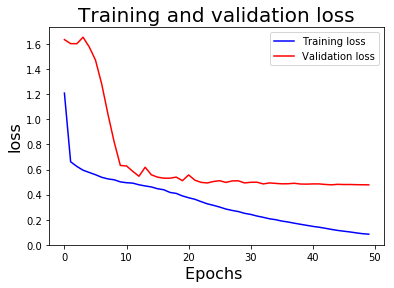

In [0]:
plot_validation_training("loss", trained_model)

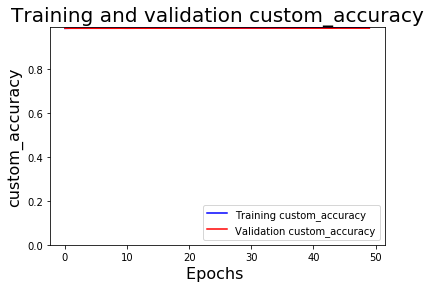

In [0]:
plot_validation_training("custom_accuracy", trained_model)

In [0]:
model.load_weights("epoch=50_loss=0.0846_mean_iou=0.9992.h5")

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
predictions = model.predict_generator(val_generator, steps=val_steps, verbose=1)

166/166 [==============================] - 102s 615ms/step


In [0]:
len(predictions)

5312

In [0]:
classes_predicted = predictions[..., 0].reshape(-1)
classes_predicted = np.where(classes_predicted >= 0.5, 1, 0)

real_classes = y_val[..., 0][:5312].reshape(-1)

In [0]:
classes_predicted.shape, real_classes.shape

((132800,), (132800,))

In [0]:
len(real_classes[real_classes == 1])

1566

In [0]:
len(real_classes[real_classes == 0])

131234

In [0]:
classes_names = ["Negatives", "Positives"]

Confusion matrix, without normalization


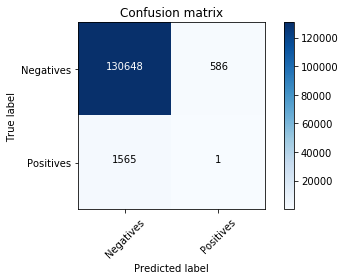

In [0]:
cm = confusion_matrix(real_classes, classes_predicted, labels=range(2))
plot_confusion_matrix(cm, classes_names)

In [0]:
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print(f'sensitivity: {sensitivity}')

specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
print(f'specificity: {specificity}')

sensitivity: 0.9955346937531432
specificity: 0.0006385696040868455


In [0]:
import cv2

In [0]:
test_generator = DataGenerator(X_val[:10], y_val[:10], batch_size=10, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

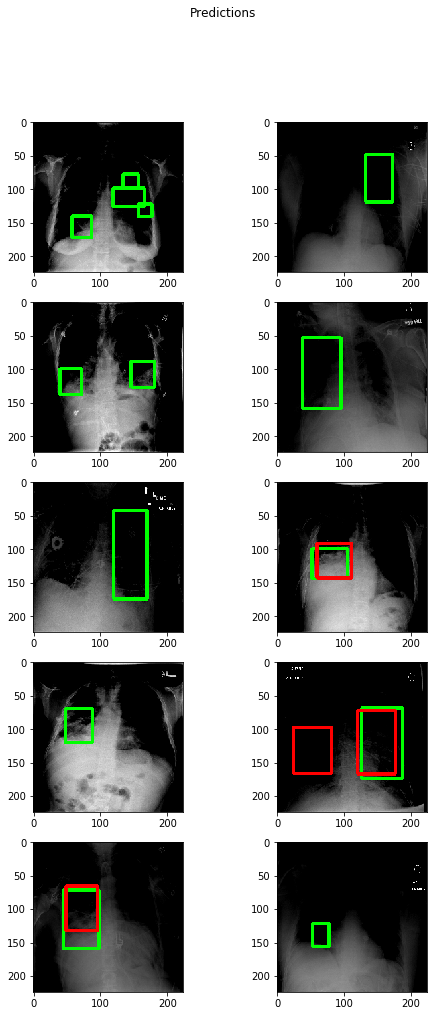

In [0]:
font = cv2.FONT_HERSHEY_SIMPLEX

for images, tensor_volumes in test_generator:
  predictions = model.predict(images)
  
  plt.figure()
  figure, axis = plt.subplots(5, 2, figsize=(8, 16))
  plt.suptitle("Predictions")
  
  plot_row_indeces_array = np.repeat([0, 1, 2, 3, 4], 2)
  plot_column_indeces_array = np.tile([0, 1], 5)
  
  for index, (predicted_tensor, tensor_volume) in enumerate(zip(predictions, tensor_volumes)):
    predicted_classes = predicted_tensor[..., 0]
    predicted_boxes = predicted_tensor[..., 1:]

    real_classes = tensor_volume[..., 0]
    real_boxes = tensor_volume[..., 1:]
    
    plot_row_index = plot_row_indeces_array[index]
    plot_column_index = plot_column_indeces_array[index]
    
    img = images[index]

    for column_index, (column_predicted_classes, column_real_classes) in enumerate(zip(predicted_classes, real_classes)):
      for row_index, (predicted_class, real_class) in enumerate(zip(column_predicted_classes, column_real_classes)):
        if real_class > 0.5:
          boxes = real_boxes[column_index][row_index] * img_size
          img = cv2.rectangle(img, (int(boxes[0]), int(boxes[1])), (int(boxes[2]), int(boxes[3])), (0, 255, 0), 3) 

        if predicted_class > 0.5:
          boxes = predicted_boxes[column_index][row_index] * img_size
          img = cv2.rectangle(img, (int(boxes[0]), int(boxes[1])), (int(boxes[2]), int(boxes[3])), (255, 0, 0), 3) 
    
    axis[plot_row_index, plot_column_index].imshow(img)
  
  break